# Earth Launcher

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
# import functions from the modsim.py module
from modsim import *
import numpy as np

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
A = UNITS.ampere
V = UNITS.volts
Ohm = UNITS.ohm
N = UNITS.newton
U_mu = N / A**2
None

In [3]:
params_railgun = Params(x = 0 * m, 
                        d = 1 * m,
                        r = 0.1 * m,
                        L = 100 * m,
                        mass = 1 * kg,
                        Vs = 1000 * V,
                        R = 0.01 * Ohm,
                        mu_0 = 1.257e-6 * U_mu,
                        t_end = 100 * s)

,values
x,0 meter
d,1 meter
r,0.1 meter
L,100 meter
mass,1 kilogram
Vs,1000 volt
R,0.01 ohm
mu_0,1.257e-06 newton / ampere ** 2
t_end,100 second


In [4]:
def make_railgun_system(params):
    """
    Make a system object.
    
    Parameters:
        params: Params object containing following:
            x: Initial position of armature (in meters)
            d: Separation distance between two rails (in meters)
            r: Radii of the rails (in meters)
            L: Length armature has to travel along rails before launch (in meters)
            mass: Mass of armature (in kilograms)
            Vs: (Initial) Voltage supply magnitude (in volts)
            R: Resistance of railgun circuit (in ohms)
            mu_0: Vacuum permeability constant (in N/A^2)
            t_end: Simulation end time (in seconds)
               
    returns: System object containing
        params values
        c_mag: Calculated magnetic force coefficient (in N/A^2)
        init: Initial state object containing:
            x: Position of armature (initialized to params.x) (in meters)
            v: Velocity of armature (initialized to 0) (in meters)
    """
    
    # make the initial state
    init = State(x=params.x, v=0)
    
    # Determine magnetic force coefficient
    c_mag = params.mu_0 * log((params.d - params.r) / params.r) / (2 * pi)
    
    return System(params, c_mag = c_mag, init=init)

In [5]:
def mag_force(I, system):
    """
    Determines magnetic force on armature due to magnetic loop of railgun. Assumes 1D system.
    
    Parameters:
        I: Current through the circuit at time of function call. (in amperes)
        system: System object containing following system parameters (relevant listed):
            c_mag: Calculated magnetic force coefficient (in N/A^2)
               
    returns: Magnitude of magnetic force
    """
    return system.c_mag * I**2

In [6]:
def railgun_slope_func(state, t, system):
    """
    Computes derivatives of the state variables. 
    Invokes function mag_force to determine magnetic force applied on armature.
    
    Parameters:
        state: Current State object at time of function call.
            x: Position of armature (initialized to params.x) (in meters)
            v: Velocity of armature (initialized to 0) (in meters)
        system: System object containing following system parameters (relevant listed):
            Vs: Magnitude of voltage supply to circuit (in volts)
            R: Resistance of the circuit (in ohms)
               
    returns: Magnitude of magnetic force (in newtons)
    """
    x, v = state

    I = system.Vs / system.R
    
    F_mag = mag_force(I, system)
    a = F_mag / system.mass
    
    return v, a

In [7]:
def event_func_railgun(state, t, system):
    """
    Stop when the position is equal to the length of rail that can be traveled.
        (stop when the distance left to travel is equal to 0)
    
    Parameters:
        state: Current State object at time of function call.
            x: Position of armature (initialized to params.x) (in meters)
            v: Velocity of armature (initialized to 0) (in meters)
        system: System object containing following system parameters (relevant listed):
            L: Length armature has to travel along rails before launch (in meters)
               
    returns: Distance the armature has left to travel.
    """
    x, v = state
    return x - system.L

In [8]:
def sim_railgun(mass, v_supply, params):  
    """
    Simulate the railgun model.
    
    Parameters:
        mass: Mass of armature (in kilograms)
        params: Params object containing following:
            x: Initial position of armature (in meters)
            d: Separation distance between two rails (in meters)
            r: Radii of the rails (in meters)
            L: Length armature has to travel along rails before launch (in meters)
            mass: Mass of armature (in kilograms)
            Vs: (Initial) Voltage supply magnitude (in volts)
            R: Resistance of railgun circuit (in ohms)
            mu_0: Vacuum permeability constant (in N/A^2)
            t_end: Simulation end time (in seconds)
               
    returns:
        x: Final position of the armature.
        v: Final velocity of the armature.
    """
    params = Params(params, mass=mass, Vs = v_supply)
    system = make_railgun_system(params)
    results, details = run_ode_solver(system, railgun_slope_func, events=event_func_railgun)
    return results.x, results.v

In [9]:
#model constituant functions
def run_simulation_after_cannon (Mass_shot, Shot_velocity, number_years_after_shot, orbital_results):
    """This code runs a simulation of the earth firing a projectile of a given mass and velocity.
    This code is intended to be run after another simulation of normal orbital motion which will inform the starting position of the earth before the projectile is fired.
    Masses are in kg
    Velocities are in m/s
    number of years after shot is a number whic dictates how long to run the simulation of the earth's orbital motion after the projectile is fired.
    This function returns a time frame containing the x and y poition and velocity of the earth throughout the simulation"""
    #gets a vector of the velocity of earth based on the results of the original simulation
    orbital_velocity = Vector(get_last_value(orbital_results.xvel),get_last_value(orbital_results.yvel))
    
    #fires the railgun
    post_cannon_velocity, post_cannon_mass = fire_cannon(orbital_velocity,5.972*10**24, Mass_shot, Shot_velocity)
    
    #runs a simulation of the earth and the sun with the earth's updated velocity allowing the ODE solver to take any step size
    escape_results = run_planet_simulation(get_last_value(orbital_results.xpos),get_last_value(orbital_results.ypos),post_cannon_velocity.x,post_cannon_velocity.y,post_cannon_mass,number_years_after_shot)
    
    #escape_results = run_planet_simulation(get_last_value(orbital_results.xpos),get_last_value(orbital_results.ypos),get_last_value(orbital_results.xvel),get_last_value(orbital_results.yvel),5.972*10**24,number_years_after_shot)
    
    #returns the results
    return escape_results

In [10]:
def fire_cannon(planet_velocity_vector, Mass_earth, Mass_shot, Shot_speed):
    """Runs a function which updates the velocity and mass of a planet assuming that it is accelerated via mass ejection.
    Calculations are based on conservation of momentum.
    Masses are in kilograms
    Speeds are in m/s
    The velocity vector describes the last known velocity of the planet.
    MODELING ASSUMPTION CONSTRAINT:  This model assumes that the earth exerts no gravitational pull on the projectile.
    This means that projectiles fired at less than their escape velocity will not be accurate to the real world where they would return to the earth and recombine with it."""
    if Shot_speed != 0:
        #calculates the magnitude of the new velocity of the planet
        velocity_vector_magnitude = (Mass_earth*planet_velocity_vector.mag + Mass_shot*Shot_speed)/(Mass_earth-Mass_shot) 
        #multiplies the magnitude by a unit vector in the direction of the last known velocity to create a velocity vector in the proper direction
        planet_velocity_vector = (planet_velocity_vector/planet_velocity_vector.mag)*velocity_vector_magnitude
 
        #updates the mass of the earth to account for the fact that the shot removed mass from the earth
        Mass_earth = Mass_earth - Mass_shot
    
    #retuns the new velocity as a vector and the new mass of the earth
    return planet_velocity_vector, Mass_earth

In [11]:
def run_planet_simulation (earth_position_x,earth_position_y, earth_velocity_x, earth_velocity_y,earth_mass,num_years):
    """This function runs a simulation of a two body planetary system. 
    This simulation assumes that the sun in the planetary system has the mass of earth's sun and is at a fixed location in space (0,0) for conveianance
    the planet's position velocity and mass are supplied to better inform the simulation.
    The number of years dictates how many years the simulation should be run for.
    Max_step_size is the maximum step size in seconds
    The function returns the trajectory of the supplied planet."""
    # creates the state for the simulation
    #distance in meteres velocity in m/s
    st8 = State(xpos = earth_position_x, 
                ypos = earth_position_y, 
                xvel = earth_velocity_x, 
                yvel = earth_velocity_y)
    #Creates a system which holds the parameters of the simulation
    #G = m^3/(kg*s^2) masses are in kg masses are in kg radi are in meteres velocities are in m/s
    sys = System(init = st8,
                 G = 6.67408*10**(-11), 
                 M_earth = earth_mass, 
                 M_sun =1.989*10**30, 
                 R_earth = 6.3781*10**6, 
                 R_sun= 6.95700*10**8, 
                 t_end = 365.25*24*60*60*num_years,
                 Earth_Radius = 6378*10**3,
                 sun_pos = Vector(0,0))
    
    #runs an ODE solver to run the simulation and restricts the ODE solver to taking steps with a maximum size of one day
    results,details = run_ode_solver(sys,planet_slope_func, max_step=60*60*24)
    
    #returns the results of the solver
    return results

In [12]:
def planet_slope_func(st8,t,sys):
    """Describes the change in position and velocity in both the x and y plane between every time step.
    The function takes in a state which describes the old position of the system
    t is the time of the syatem, it is not actually used in calculations however it is a required argument for use with an ODE Solver
    sys is a system object which contains system constants"""
    
    #extracts the values from the state because the ODE solver does not store variables in a state object
    xpos,ypos,xvel,yvel= st8
    #creates a vector which describes the position of the planet
    planet_pos = Vector(xpos,ypos)
    
    #describes a system of differential equations which explain the changes in the system
    #update the velocity in each direction
    dxveldt = get_grav_acceleration(sys.G, sys.M_sun, sys.M_earth, planet_pos,sys.sun_pos).x
    dyveldt = get_grav_acceleration(sys.G, sys.M_sun, sys.M_earth, planet_pos,sys.sun_pos).y
    
    #update the position in each direction
    dxposdt = xvel
    dyposdt = yvel
    
    #returns the change in the state variables
    return dxposdt,dyposdt,dxveldt,dyveldt

In [13]:
def get_grav_acceleration(G,M,m,planet_vector,sun_vector):
    """Calculates acceleration due to gravity with F = ma
    F in N
    m in kg
    a in m/s^2"""
    #gets the force and divides by the orbiting body to get the acceleration of the orbing body
    return get_gravitational_force(G,M,m,planet_vector,sun_vector)/m

In [14]:
def get_gravitational_force(G,M,m,planet_vector, sun_vector):
    """Applies law of universal gravitation and returns the force of gravity as a vector towards the center of the circle in N"""
    #calculates the vector pointing from the planet to the sun
    planet_to_sun_vector = sun_vector-planet_vector
    #takes the direction of the previous vector
    Direction_vector = planet_to_sun_vector/planet_to_sun_vector.mag
    #calculates the acceleration of the planet
    acceleration_mag = (G*M*m)/(planet_vector.mag**2)
    #returns a vector which has the magnitude of the acceleration and a direction towards the star
    return Direction_vector * acceleration_mag

In [18]:
def launch_simulation(mass_armature, railgun_voltage, railgun_params, 
                      sim_t_end, orbital_results):
    # Simulate railgun launch
    rail_x, rail_v = sim_railgun(mass_armature, railgun_voltage, railgun_params)
    
    final_armature_speed = get_last_value(rail_v)
    # Simulate after-effects of railgun launch
    shot_results = run_simulation_after_cannon(mass_armature, final_armature_speed, 
                                               sim_t_end, orbital_results)
    
    return shot_results

# Results

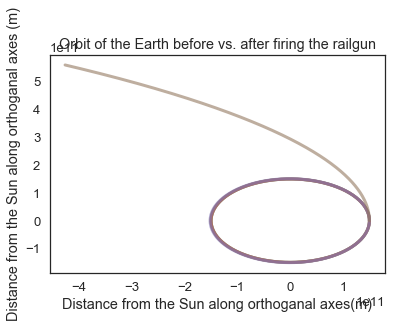

In [27]:
orbital_results = run_planet_simulation(149597900000,0, 0, 29785,5.972*10**24,1) 
plt.figure(1)
plot(orbital_results.xpos, orbital_results.ypos)
# Inputs as parameters

possible_masses = np.logspace(10, 24,5)
for mass in possible_masses:
    v_s = 1e15 * V
    shot_results = launch_simulation(mass, v_s, params_railgun, 1, orbital_results)
    plot(shot_results.xpos,shot_results.ypos, label = str(mass)+ " kg")
plt.xlabel('Distance from the Sun along orthoganal axes(m)')
plt.ylabel('Distance from the Sun along orthoganal axes (m)')
plt.title('Orbit of the Earth before vs. after firing the railgun')
None

In [28]:
fin_v = pd.Series(index = possible_masses)
for mass in possible_masses:
    v_s = 1e27 * V
    x, v = sim_railgun(mass, v_s, params_railgun)
    fin_v[mass] = get_last_value(v)
fin_v

1.000000e+10    0.000000e+00
3.162278e+13    0.000000e+00
1.000000e+17    0.000000e+00
3.162278e+20    0.000000e+00
1.000000e+24    2.880313e+16
dtype: float64

In [26]:
1e27

1e+27